### Import libraries

In [1]:
import sys
import os
import gc
from functools import partial
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from DataSetUp import *
from EmbedCarPrice import *
%load_ext autoreload
%autoreload 2

In [4]:
EmbedCarPrice.set_gpu_limit(6)

### Split none onehot encoded data into train,dev and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price 

In [6]:
data_setup = DataSetUp(features,y)
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,True,2020,0.11)

### We will embed columns model, transmission, fuelType, and brand

--- 

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants for base model

In [8]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [9]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

* model embed model input 
* transmission embed model input
* brand embed model input 
* fuelType embed model input 
* numeric input data 

### Perform categorical feature transformation

In [10]:
data_setup.categorical_mapping(X_train,EMBED_COLS)
X_train_list,X_dev_list  = data_setup.cate_data_list(X_train),data_setup.cate_data_list(X_dev)

In [11]:
X_train_dataset, X_dev_dataset = (X_train_list,y_train),(X_dev_list,y_dev)

In [25]:
X_test_list,features_list = data_setup.cate_data_list(X_test), data_setup.cate_data_list(features)

In [13]:
base_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS, 
                                                   X_train,numeric_size,
                                                   model_size,DROPOUT,METRICS,lr)

In [15]:
carPrice_embed = EmbedCarPrice(base_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [17]:
carPrice_embed.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,0)

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


r2_score        rmse  price_diff_abs_max
train   0.70963  5315.26343         1084.933998

In [18]:
carPrice_embed.regression_metrics(X_test_list,y_test,"test",False)

r2_score         rmse  price_diff_abs_max
test  0.704456  5244.013784          290.961967

In [20]:
base_embed_model_trained = carPrice_embed._trained_model

In [21]:
EmbedCarPrice.save_model(base_embed_model_trained,"cate_embed_base_model.h5")

In [22]:
base_embed_model = EmbedCarPrice.load_model("cate_embed_base_model.h5")

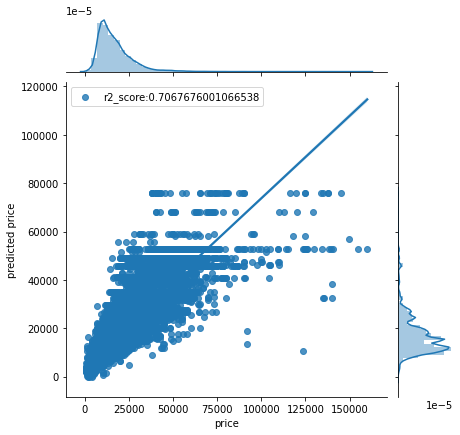

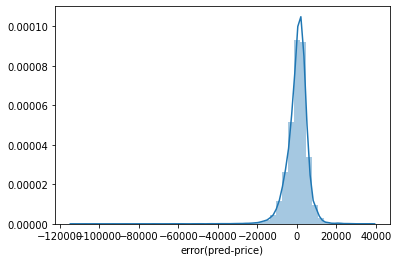

In [26]:
carPrice_embed.plot_pred_price(features_list,y)

In [28]:
price_table = carPrice_embed.price_diff(features,y,features_list)

In [29]:
price_table.head(20)

model transmission fuelType     brand  binned_year  mil_cat  \
20061     Beetle    Automatic   Petrol        vw            1        0   
39711    C Class    Automatic   Diesel      merc            1        2   
71819     Mondeo       Manual   Diesel      ford            1        0   
11984       Golf       Manual   Diesel        vw            1        0   
69135     Mondeo       Manual   Diesel      ford            1        4   
54900      Agila       Manual   Petrol  vauxhall            1        4   
77582   Santa Fe       Manual   Petrol    hyundi            1        4   
52100     Zafira       Manual   Diesel  vauxhall            2        5   
44745      Astra       Manual   Diesel  vauxhall            1        5   
44553      Corsa       Manual   Petrol  vauxhall            1        4   
44539      Corsa       Manual   Petrol  vauxhall            1        4   
71571      C-MAX       Manual   Petrol      ford            1        0   
6427     Avensis       Manual   Diesel    toyota            1        5   
289      Corolla    Automatic   Petrol    toyota            1        4   
71617     Fiesta       Manual   Petrol      ford            1        4   
44573      Corsa       Manual   Petrol  vauxhall            1        4   
47347      Astra       Manual   Diesel  vauxhall            1        5   
52386     Meriva       Manual   Diesel  vauxhall            2        5   
70592     Fiesta       Manual   Diesel      ford            1        4   
44645      Corsa       Manual   Petrol  vauxhall            1        3   

       binned_mpg  engine_binned  price_diff_pct  price_diff_abs  
20061           1              0     1084.933998     1084.933998  
39711           1              1      987.711708      987.711708  
71819           2              0      876.642940      876.642940  
11984           3              0      812.145235      812.145235  
69135           2              0      752.132812      752.132812  
54900           2              0      621.770725      621.770725  
77582           1              1      541.049438      541.049438  
52100           3              0      468.851577      468.851577  
44745           3              0      455.575364      455.575364  
44553           2              0      450.503095      450.503095  
44539           3              0      436.469184      436.469184  
71571           1              0      433.962739      433.962739  
6427            2              0      372.582577      372.582577  
289             1              0      369.997643      369.997643  
71617           2              0      368.006954      368.006954  
44573           2              0      363.995466      363.995466  
47347           3              0      354.264562      354.264562  
52386           4              0      331.149264      331.149264  
70592           4              0      324.144211      324.144211  
44645           2              0      321.472346      321.472346

### much worse than other models, may need more embed

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [30]:
EMBED_COLS = ["model","transmission","brand","fuelType"]
NONEMBED_COLS = [c for c in X_train.columns if c not in EMBED_COLS]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [39]:
bigger_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,NONEMBED_COLS,
                                                     X_train,numeric_size,model_size,DROPOUT,METRICS,lr,10)

In [40]:
bigger_embed_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [41]:
carPrice_embed_bigger = EmbedCarPrice(bigger_embed_model,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [42]:
carPrice_embed_bigger.regression_metrics(X_train_list,y_train,"train",True,X_train_dataset,X_dev_dataset,1)

Epoch 1/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 44977340.0000 - MAPE: 30.4439 - MAE: 4523.8398 - val_loss: 35898416.0000 - val_MAPE: 26.3712 - val_MAE: 4005.7427
Epoch 2/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 31186956.0000 - MAPE: 26.1340 - MAE: 3858.0408 - val_loss: 34086516.0000 - val_MAPE: 25.7799 - val_MAE: 3868.1218
Epoch 3/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 30676826.0000 - MAPE: 25.9597 - MAE: 3821.2241 - val_loss: 34113828.0000 - val_MAPE: 26.0498 - val_MAE: 3873.5364
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 30440736.0000 - MAPE: 25.8495 - MAE: 3805.6565 - val_loss: 35152644.0000 - val_MAPE: 29.3419 - val_MAE: 4058.7659
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 30164292.0000 - MAPE: 25.8604 - MAE: 3796.6987 - val_loss: 34012420.0000 - val_MAPE: 27.0162 - val_MAE: 3928.1426
Epoch 6/1000
2483/2483 [================

KeyboardInterrupt: 

In [28]:
bigger_embed = carPrice_embed_bigger.trained_model

In [29]:
EmbedCarPrice.save_model(bigger_embed,"bigger_embed.h5")

In [30]:
bigger_embed = EmbedCarPrice.load_model("bigger_embed.h5")

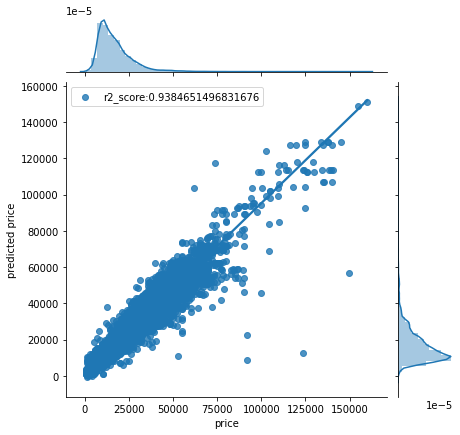

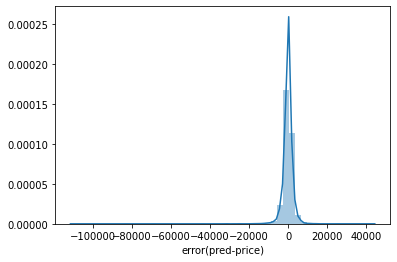

In [31]:
carPrice_embed_bigger.plot_pred_price

In [32]:
price_table = carPrice_embed_bigger.price_diff

In [33]:
price_table.head(20)

model transmission fuelType  binned_year  mil_cat  binned_mpg  \
20061     Beetle    Automatic   Petrol            1        0           1   
11984       Golf       Manual   Diesel            1        0           3   
39711    C Class    Automatic   Diesel            1        2           1   
71819     Mondeo       Manual   Diesel            1        0           2   
77582   Santa Fe       Manual   Petrol            1        4           1   
69135     Mondeo       Manual   Diesel            1        4           2   
39978    A Class       Manual   Petrol            1        5           1   
44539      Corsa       Manual   Petrol            1        4           3   
39540    M Class    Semi-Auto   Petrol            1        5           1   
71617     Fiesta       Manual   Petrol            1        4           2   
72349      Focus       Manual   Petrol            1        4           2   
83274         Z4       Manual   Petrol            2        3           2   
40019    C Class    Automatic   Petrol            1        3           1   
289      Corolla    Automatic   Petrol            1        4           1   
72016      Focus       Manual   Petrol            1        5           2   
78800         X3    Semi-Auto   Diesel            2        2           3   
44553      Corsa       Manual   Petrol            1        4           2   
71571      C-MAX       Manual   Petrol            1        0           1   
6309       Prius    Automatic   Hybrid            1        5           4   
52100     Zafira       Manual   Diesel            2        5           3   

       engine_binned  price_diff_pct  price_diff_abs  
20061              0      793.600800      793.600800  
11984              0      712.023898      712.023898  
39711              1      594.681098      594.681098  
71819              0      580.404097      580.404097  
77582              1      479.667562      479.667562  
69135              0      442.220595      442.220595  
39978              0      428.790678      428.790678  
44539              0      415.699229      415.699229  
39540              1      402.148829      402.148829  
71617              0      318.660540      318.660540  
72349              0      294.900593      294.900593  
83274              0      286.319299      286.319299  
40019              0      260.327377      260.327377  
289                0      258.641220      258.641220  
72016              0      256.823311      256.823311  
78800              0      252.915976      252.915976  
44553              0      246.036377      246.036377  
71571              0      243.090074      243.090074  
6309               0      236.831123      236.831123  
52100              0      232.830981      232.830981

### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [34]:
EMBED_COLS = ["model","transmission","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [35]:
all_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [36]:
carPrice_embed_all = EmbedCarPrice(data,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [37]:
carPrice_embed_all.set_base_model(all_embed_model)
carPrice_embed_all.cate_embed_process(X_train,y_train,X_dev,y_dev,X_test,y_test,EMBED_COLS)

In [42]:
carPrice_embed_all.regression_metrics(carPrice_embed_all._train_list[0], y_train,
                                      carPrice_embed_all._test_list,y_test,
                                      retrain=False)

r2_score         rmse  price_diff_abs_max
train  0.941081  2390.262664          491.193910
test   0.933194  2604.307723          246.534559

In [39]:
all_embed = carPrice_embed_all.trained_model

In [40]:
EmbedCarPrice.save_model(all_embed,"All_embed.h5")

In [41]:
all_embed = EmbedCarPrice.load_model("All_embed.h5")

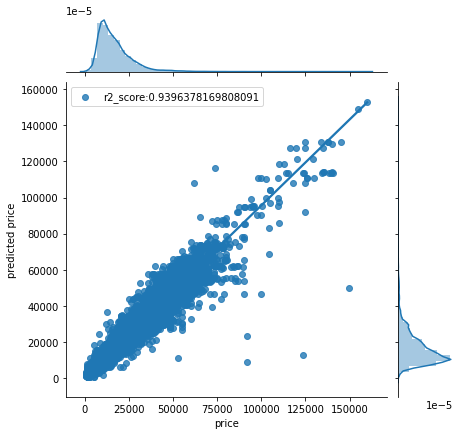

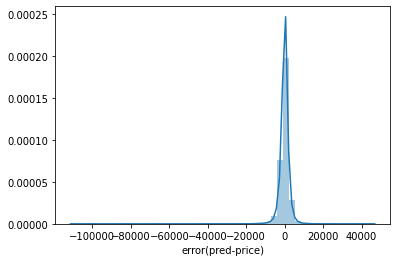

In [43]:
carPrice_embed_all.plot_pred_price

In [44]:
price_table = carPrice_embed_all.price_diff
price_table.head(20)

model transmission fuelType  binned_year  mil_cat  binned_mpg  \
11984       Golf       Manual   Diesel            1        0           3   
20061     Beetle    Automatic   Petrol            1        0           1   
44539      Corsa       Manual   Petrol            1        4           3   
71819     Mondeo       Manual   Diesel            1        0           2   
39711    C Class    Automatic   Diesel            1        2           1   
87481   3 Series    Automatic   Petrol            0        4           1   
69135     Mondeo       Manual   Diesel            1        4           2   
77582   Santa Fe       Manual   Petrol            1        4           1   
71617     Fiesta       Manual   Petrol            1        4           2   
47201      Astra       Manual   Petrol            1        5           2   
87743   3 Series    Automatic   Petrol            0        4           1   
39540    M Class    Semi-Auto   Petrol            1        5           1   
39978    A Class       Manual   Petrol            1        5           1   
83274         Z4       Manual   Petrol            2        3           2   
78800         X3    Semi-Auto   Diesel            2        2           3   
44553      Corsa       Manual   Petrol            1        4           2   
72016      Focus       Manual   Petrol            1        5           2   
72349      Focus       Manual   Petrol            1        4           2   
54900      Agila       Manual   Petrol            1        4           2   
289      Corolla    Automatic   Petrol            1        4           1   

       engine_binned  price_diff_pct  price_diff_abs  
11984              0      491.193910      491.193910  
20061              0      482.320906      482.320906  
44539              0      429.793442      429.793442  
71819              0      417.313348      417.313348  
39711              1      412.315074      412.315074  
87481              1      409.452962      409.452962  
69135              0      389.173647      389.173647  
77582              1      379.552653      379.552653  
71617              0      310.709471      310.709471  
47201              0      307.063612      307.063612  
87743              1      294.415197      294.415197  
39540              1      288.717497      288.717497  
39978              0      274.076172      274.076172  
83274              0      259.839661      259.839661  
78800              0      252.471575      252.471575  
44553              0      250.806202      250.806202  
72016              0      246.534559      246.534559  
72349              0      243.735781      243.735781  
54900              0      242.550212      242.550212  
289                0      227.423917      227.423917

### Slightly improved, still have same issues with older year. Let's import original raw data

In [45]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv").drop("brand",axis=1)

In [46]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99186 non-null  object 
 1   year          99186 non-null  int64  
 2   price         99186 non-null  int64  
 3   transmission  99186 non-null  object 
 4   mileage       99186 non-null  int64  
 5   fuelType      99186 non-null  object 
 6   mpg           99186 non-null  float64
 7   engineSize    99186 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [47]:
EMBED_COLS = ["model","transmission","fuelType","year"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [49]:
carPrice_embed_raw = EmbedCarPrice(data_raw,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [53]:
X_train_r,X_test_r,y_train_r,y_test_r,X_dev_r,y_dev_r  = carPrice_embed_raw.data_split(1988,0.1)

In [54]:
raw_embed_model = EmbedCarPrice.embed_model_setup(EMBED_COLS,X_train_r,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [60]:
carPrice_embed_raw.set_base_model(raw_embed_model)
carPrice_embed_raw.cate_embed_process(X_train_r,y_train_r,X_dev_r,y_dev_r,X_test_r,y_test_r,EMBED_COLS)

In [69]:
carPrice_embed_raw.regression_metrics(carPrice_embed_raw._train_list[0],y_train_r,
                                  carPrice_embed_raw._test_list,y_test_r,
                                  retrain=False)

r2_score         rmse  price_diff_abs_max
train  0.921495  2759.079305          676.094742
test   0.909136  3037.257711          693.037751

In [64]:
embed_model_r = carPrice_embed_raw.trained_model

In [65]:
EmbedCarPrice.save_model(embed_model_r,"model_embed_raw.h5")

In [66]:
embed_model_r = EmbedCarPrice.load_model("model_embed_raw.h5")

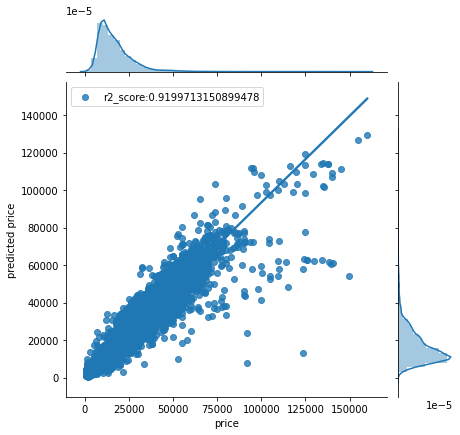

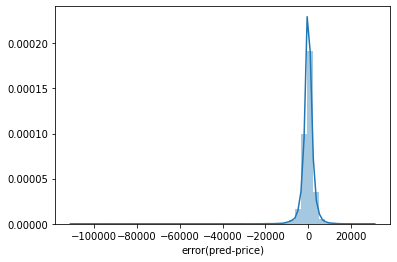

In [67]:
carPrice_embed_raw.plot_pred_price

In [68]:
price_table = carPrice_embed_raw.price_diff
price_table.head(20)

model  year transmission  mileage fuelType   mpg  engineSize  \
72016     Focus  2003       Manual   177644   Petrol  41.5         1.6   
11984      Golf  2008       Manual        1   Diesel  53.3         1.9   
39978   A Class  2003       Manual   109090   Petrol  40.0         1.4   
71819    Mondeo  2008       Manual        1   Diesel  47.9         2.0   
27964   Octavia  2010       Manual   300000   Diesel  57.6         1.9   
39336   S Class  2001    Automatic   108800   Diesel  31.7         3.2   
6427    Avensis  2003       Manual   167054   Diesel  48.7         2.0   
52100    Zafira  2013       Manual   279000   Diesel  55.4         1.7   
40170   A Class  2010       Manual   116126   Diesel  54.3         2.0   
83274        Z4  2014       Manual    31074   Petrol  41.5         2.0   
54900     Agila  2003       Manual    90000   Petrol  43.5         1.2   
39711   C Class  2002    Automatic    13800   Diesel  39.8         2.7   
69135    Mondeo  2005       Manual    97000   Diesel  48.7         2.0   
44745     Astra  2005       Manual   150000   Diesel  57.7         1.7   
44309     Corsa  2010       Manual   104000   Diesel  67.3         1.2   
13060    Passat  2010       Manual   168000   Diesel  60.1         2.0   
27480   Octavia  2010       Manual   250650   Diesel  57.6         1.9   
20061    Beetle  2001    Automatic        1   Petrol  29.7         2.0   
47347     Astra  2006       Manual   139905   Diesel  54.3         1.7   
71817     Focus  2005       Manual   121000   Petrol  39.8         2.0   

       price_diff_pct  price_diff_abs  
72016      693.037751      693.037751  
11984      676.094742      676.094742  
39978      586.948167      586.948167  
71819      512.131440      512.131440  
27964      421.157883      421.157883  
39336      391.225975      391.225975  
6427       377.015596      377.015596  
52100      362.989366      362.989366  
40170      353.583008      353.583008  
83274      345.089630      345.089630  
54900      338.103706      338.103706  
39711      315.146550      315.146550  
69135      306.801613      306.801613  
44745      300.419676      300.419676  
44309      289.484999      289.484999  
13060      289.322057      289.322057  
27480      287.747396      287.747396  
20061      278.276726      278.276726  
47347      272.132899      272.132899  
71817      270.904803      270.904803

### Let's use numeric binned data instead

In [70]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)

In [111]:
EMBED_COLS = ["model","transmission","fuelType","year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [73]:
carPrice_embed_c = EmbedCarPrice(combined,BATCH_SIZE,MAX_EPOCH,[earlystop])

In [74]:
X_train_c,X_test_c,y_train_c,y_test_c,X_dev_c,y_dev_c  = carPrice_embed_c.data_split(1988,0.1)

In [75]:
embed_model_c = EmbedCarPrice.embed_model_setup(EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [76]:
embed_model_c.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [77]:
carPrice_embed_c.set_base_model(embed_model_c)
carPrice_embed_c.cate_embed_process(X_train_c,y_train_c,X_dev_c,y_dev_c,X_test_c,y_test_c,EMBED_COLS)

In [84]:
carPrice_embed_c.regression_metrics(carPrice_embed_c._train_list,y_train_c,
                                    carPrice_embed_c._test_list,y_test_c,retrain=False)

r2_score         rmse  price_diff_abs_max
train  0.952892  2137.300861          480.879523
test   0.943111  2403.264800          217.666755

In [79]:
embed_model_c = carPrice_embed_c.trained_model

In [80]:
EmbedCarPrice.save_model(embed_model_c,"combined_embed_all.h5")

In [81]:
embed_model_c= EmbedCarPrice.load_model("combined_embed_all.h5")

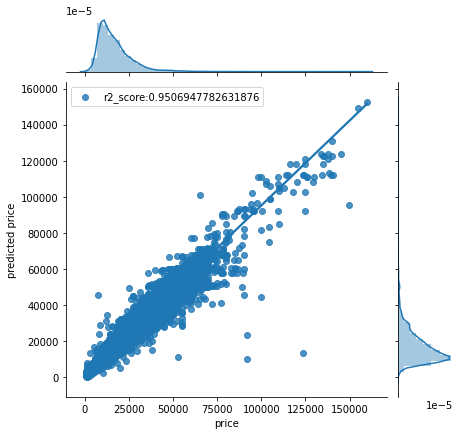

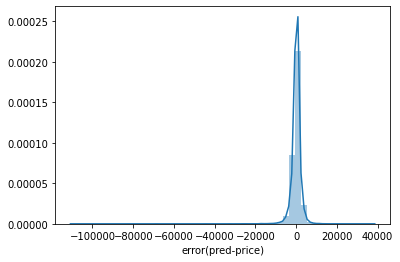

In [82]:
carPrice_embed_c.plot_pred_price

In [83]:
price_table = carPrice_embed_c.price_diff
price_table.head(20)

model transmission fuelType  mil_cat  binned_mpg  engine_binned  \
72229        Kuga       Manual   Petrol        3           1              1   
71819      Mondeo       Manual   Diesel        0           2              0   
11984        Golf       Manual   Diesel        0           3              0   
71617      Fiesta       Manual   Petrol        4           2              0   
83274          Z4       Manual   Petrol        3           2              0   
77582    Santa Fe       Manual   Petrol        4           1              1   
87481    3 Series    Automatic   Petrol        4           1              1   
69135      Mondeo       Manual   Diesel        4           2              0   
39711     C Class    Automatic   Diesel        2           1              1   
20061      Beetle    Automatic   Petrol        0           1              0   
39978     A Class       Manual   Petrol        5           1              0   
54464    Insignia       Manual   Petrol        4           1              1   
40170     A Class       Manual   Diesel        5           3              0   
72016       Focus       Manual   Petrol        5           2              0   
78800          X3    Semi-Auto   Diesel        2           3              0   
29517   GLE Class    Semi-Auto   Diesel        4           2              1   
54900       Agila       Manual   Petrol        4           2              0   
52100      Zafira       Manual   Diesel        5           3              0   
27964     Octavia       Manual   Diesel        5           3              0   
44553       Corsa       Manual   Petrol        4           2              0   

       year  price_diff_pct  price_diff_abs  
72229  2011      506.047838      506.047838  
71819  2008      480.879523      480.879523  
11984  2008      416.898591      416.898591  
71617  2008      389.379425      389.379425  
83274  2014      328.613059      328.613059  
77582  2002      319.810628      319.810628  
87481  1999      309.838135      309.838135  
69135  2005      271.877857      271.877857  
39711  2002      271.066413      271.066413  
20061  2001      269.269267      269.269267  
39978  2003      251.048678      251.048678  
54464  2011      238.503378      238.503378  
40170  2010      231.332031      231.332031  
72016  2003      217.666755      217.666755  
78800  2013      215.268285      215.268285  
29517  2016      210.404637      210.404637  
54900  2003      205.197103      205.197103  
52100  2013      203.474147      203.474147  
27964  2010      195.561811      195.561811  
44553  2003      189.425401      189.425401

### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

2511/2511 [==============================] - 9s 3ms/step - loss: 378606336.0000 - MAPE: 100.0000 - MAE: 16782.0293 - val_loss: 384747424.0000 - val_MAPE: 99.9943 - val_MAE: 16988.9277


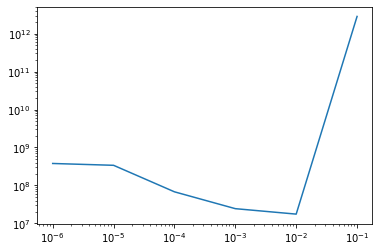

In [95]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
mdl_setup = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=4.0)
carPrice_embed_c.param_search(learning_rates,mdl_setup,1)

### learning rate of 0.001 seems to work the best

### tune embed multiplier

In [100]:
mdl_partial = partial(EmbedCarPrice.embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2511/2511 [==============================] - 9s 3ms/step - loss: 23780898.0000 - MAPE: 18.5887 - MAE: 2761.4470 - val_loss: 12196392.0000 - val_MAPE: 15.6310 - val_MAE: 2344.3984


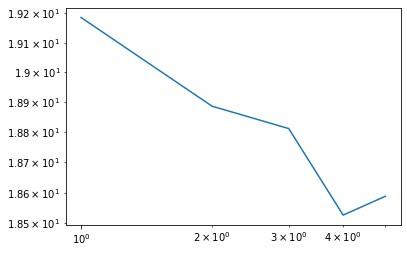

In [102]:
multiplier = [1,2,3,4,5]
carPrice_embed_c.param_search(multiplier,mdl_partial,1,optimizer="MAPE")

### multipler of 3 seems to work the best

In [103]:
final_mdl = mdl_partial(3)

In [104]:
final_mdl.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_170 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_171 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_172 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_173 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [129]:
carPrice_embed_c.set_base_model(final_mdl)
carPrice_embed_c.regression_metrics(carPrice_embed_c._train_list,y_train_c,
                                    carPrice_embed_c._test_list,y_test_c,retrain=False)

r2_score         rmse  price_diff_abs_max
train  0.953888  2114.578694          376.216418
test   0.943207  2401.223337          213.027545

In [124]:
final_mdl = carPrice_embed_c.trained_model

In [125]:
EmbedCarPrice.save_model(final_mdl,"final_embed_mdl.h5")

In [126]:
EmbedCarPrice.load_model("final_embed_mdl.h5")

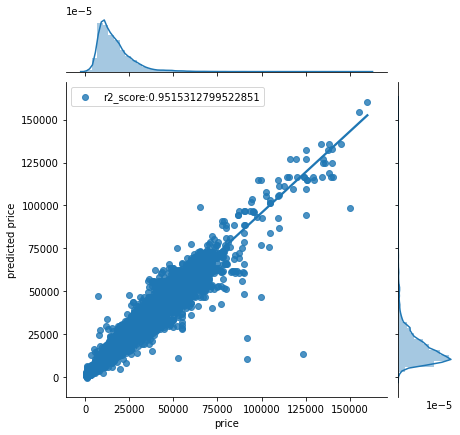

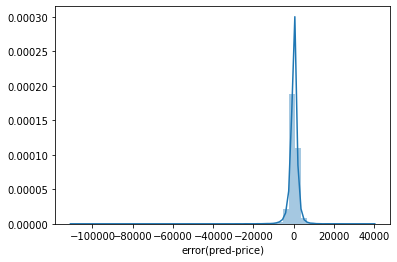

In [127]:
carPrice_embed_c.plot_pred_price

In [128]:
price_table = carPrice_embed_c.price_diff
price_table.head(20)

model transmission fuelType  mil_cat  binned_mpg  engine_binned  \
72229        Kuga       Manual   Petrol        3           1              1   
11984        Golf       Manual   Diesel        0           3              0   
71819      Mondeo       Manual   Diesel        0           2              0   
83274          Z4       Manual   Petrol        3           2              0   
77582    Santa Fe       Manual   Petrol        4           1              1   
71617      Fiesta       Manual   Petrol        4           2              0   
69135      Mondeo       Manual   Diesel        4           2              0   
39978     A Class       Manual   Petrol        5           1              0   
87481    3 Series    Automatic   Petrol        4           1              1   
39711     C Class    Automatic   Diesel        2           1              1   
54464    Insignia       Manual   Petrol        4           1              1   
40170     A Class       Manual   Diesel        5           3              0   
52100      Zafira       Manual   Diesel        5           3              0   
20061      Beetle    Automatic   Petrol        0           1              0   
29517   GLE Class    Semi-Auto   Diesel        4           2              1   
27964     Octavia       Manual   Diesel        5           3              0   
78800          X3    Semi-Auto   Diesel        2           3              0   
44553       Corsa       Manual   Petrol        4           2              0   
39540     M Class    Semi-Auto   Petrol        5           1              1   
54900       Agila       Manual   Petrol        4           2              0   

       year  price_diff_pct  price_diff_abs  
72229  2011      528.374773      528.374773  
11984  2008      376.216418      376.216418  
71819  2008      350.454150      350.454150  
83274  2014      320.912978      320.912978  
77582  2002      303.054077      303.054077  
71617  2008      291.526210      291.526210  
69135  2005      251.513491      251.513491  
39978  2003      251.150316      251.150316  
87481  1999      239.378682      239.378682  
39711  2002      227.305210      227.305210  
54464  2011      226.832734      226.832734  
40170  2010      224.708370      224.708370  
52100  2013      222.281656      222.281656  
20061  2001      219.538582      219.538582  
29517  2016      213.027545      213.027545  
27964  2010      208.018624      208.018624  
78800  2013      206.923660      206.923660  
44553  2003      190.562123      190.562123  
39540  2004      181.737865      181.737865  
54900  2003      177.431613      177.431613

### Conclusions

### More tuning on dropout and other params can enhance the models but embed gives the best results